In [1]:
%matplotlib auto
import os
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns
import shap
import xgboost as xgb


import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data.dataloader as dataloader

import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Using matplotlib backend: Qt5Agg


In [17]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        
        channels_conv1 = 1
        
        self.Conv_Layers = nn.Sequential(
            nn.Conv2d(channels_conv1,10,kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=3),
            nn.Dropout2d(),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
        )
        
        self.Linear_Layers = nn.Sequential(
            nn.Linear(500,64),
            nn.ReLU(),
            nn.Linear(64,10),
            nn.ReLU(),
            nn.LogSoftmax(),
        )
        
    def forward(self, x):
        x = self.Conv_Layers(x)
        x = torch.flatten(x, 1)
        x = self.Linear_Layers(x)
        
        return x

In [3]:
def cnn_config():

    config = {
          'batch_size_train':64,
          'batch_size_test':1000,
          'log_interval':40,      #How often to dislay (batch) loss during training
          'epochs': 20,           #Number of epochs
          'learning_rate': 0.0001,
         }
    return config

In [4]:
def run_epoch(model, epoch, data_loader, optimizer, is_training, config):
    if is_training==True: 
        model.train()
    else:
        model.eval()

    total_loss = 0 
    correct = 0 
    labels_list = [0,1,2,3,4,5,6,7,8,9]

    for batch_idx, (features,target) in enumerate(data_loader):
        
        if not is_training:
            with torch.no_grad():
                prediction = model(features)
                loss = F.nll_loss(prediction,target)
                total_loss = total_loss + loss.detach().cpu().numpy()  
            
        elif is_training:
            prediction = model(features)
            loss = F.nll_loss(prediction,target)
            total_loss = total_loss + loss.detach().cpu().numpy() 

            #Update gradients based on loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            

        # Compute the correct classification
        predicted_label = np.zeros(prediction.shape)
        predicted_label = np.argmax(prediction.detach().numpy(), axis=-1)
    loss_avg = total_loss / len(data_loader)
    accuracy = accuracy_score(predicted_label, target)

    print(f'Epoch={epoch} | loss = {total_loss/(batch_idx+1)} | accuracy = {accuracy}')
    
    return loss_avg, accuracy

In [5]:
def run_prediction(model,features):
    with torch.no_grad():
        prediction = model(features)
        predicted_label = np.zeros(prediction.shape)
        predicted_label = np.argmax(prediction.detach().numpy(), axis=-1)
    pred = F.softmax(prediction)
    pred = pred.detach().numpy()
    return predicted_label, np.max(pred)

In [6]:
def compress_image(image, size):
    U, s, V = np.linalg.svd(image,full_matrices=False)
    op1 = np.dot(np.diag(s[:size]),V[:size,:])
    compressed = np.dot(U[:,:size], op1)
    return compressed

In [7]:
def nothing(x):
    pass

In [8]:
 def draw_on_gui(event, x, y, flags, params): #params
    global draw, window
    
    if event == cv2.EVENT_LBUTTONDOWN:
        draw=True
        cv2.circle( window, (x,y), cv2.getTrackbarPos("Brush Size", title), (255,255,255), -1 )
        
    elif event == cv2.EVENT_MOUSEMOVE:
        if draw:
            cv2.circle( window, (x,y), cv2.getTrackbarPos("Brush Size", title), (255,255,255), -1 )
    
    elif event == cv2.EVENT_LBUTTONUP:
        draw=False
        cv2.circle( window, (x,y), cv2.getTrackbarPos("Brush Size", title), (255,255,255), -1 )

In [9]:
def clear_window(*args):
    cv2.rectangle(window, (0,0), (839,839), (0,0,0),-1)
    return window

In [10]:
def update_loop(title, window,model):
    count = 0
    while True:
        count += 1
        cv2.imshow(title, window)
        key = cv2.waitKey(1)
        #print(draw)
        if key==ord("q"):
            break
        
        cur = cv2.resize(window, dsize=(28, 28), interpolation=cv2.INTER_CUBIC)
        cur = cur/255
        
        data = torch.tensor(cur)
        data = data.double()
        data.unsqueeze_(0).unsqueeze_(0)
        pred, prob = run_prediction(model.double(),data)
        
        if count%100 == 0:
            print(pred, prob)
        
        if count == 1000:
            count = 0
            
    cv2.destroyAllWindows()
    

In [11]:
def show_images_from_batches(dataloader,k):
    c = 1
    for i, (image, target) in enumerate(dataloader):
        plt.subplot(1, k, c)
        plt.axis('off')
        img = image[0,0,:,:]
        plt.imshow(img, cmap=plt.cm.gray_r, interpolation='nearest')
        if c==k:
            break
        c+=1
    plt.show()

In [18]:
cconf = cnn_config()

DL_train = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])), batch_size=cconf['batch_size_train'], shuffle=True)

DL_test = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=cconf['batch_size_test'], shuffle=True)

CNNmodel = CNNClassifier()
optimizer = optim.Adam(CNNmodel.parameters(), lr=0.0001, weight_decay=0.01)#001)

loss_train = np.zeros(shape=cconf['epochs'])
acc_train = np.zeros(shape=cconf['epochs'])
loss_test = np.zeros(shape=cconf['epochs'])
acc_test = np.zeros(shape=cconf['epochs'])

for epoch in range(cconf['epochs']):
    loss_train[epoch],acc_train[epoch] = run_epoch(CNNmodel,epoch,DL_train,optimizer,True,cconf)
    loss_test[epoch],acc_test[epoch] = run_epoch(CNNmodel,epoch,DL_test,optimizer,False,cconf)

Epoch=0 | loss = 0.8719135157620983 | accuracy = 0.90625
Epoch=0 | loss = 0.274331858754158 | accuracy = 0.937
Epoch=1 | loss = 0.30603417793094223 | accuracy = 0.96875
Epoch=1 | loss = 0.19327524453401565 | accuracy = 0.943
Epoch=2 | loss = 0.23835919530931185 | accuracy = 0.9375
Epoch=2 | loss = 0.15859853178262712 | accuracy = 0.943
Epoch=3 | loss = 0.19974441211948643 | accuracy = 0.9375
Epoch=3 | loss = 0.1269892029464245 | accuracy = 0.97
Epoch=4 | loss = 0.17661763408751502 | accuracy = 0.96875
Epoch=4 | loss = 0.10976491197943687 | accuracy = 0.973
Epoch=5 | loss = 0.16206388694565815 | accuracy = 0.90625
Epoch=5 | loss = 0.10216489359736443 | accuracy = 0.976
Epoch=6 | loss = 0.15070726938331241 | accuracy = 0.9375
Epoch=6 | loss = 0.09296474307775497 | accuracy = 0.976
Epoch=7 | loss = 0.14099297164154967 | accuracy = 0.96875
Epoch=7 | loss = 0.08550019338726997 | accuracy = 0.975
Epoch=8 | loss = 0.13369282200606838 | accuracy = 0.96875
Epoch=8 | loss = 0.08175333887338639 |

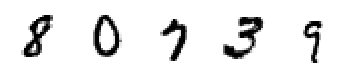

In [19]:
show_images_from_batches(DL_train,5)

In [20]:
title = "Neural Network Guesser"
draw = False
mat = np.zeros((840,840),np.uint8)#np.ones((840,840),np.uint8)*255

cv2.namedWindow(title)

window = cv2.rectangle(mat, (0,0), (839,839), (0,0,0),-1)
cv2.createTrackbar("Brush Size", title, 33, 50, nothing)
cv2.createButton("Clear", clear_window)
cv2.setMouseCallback(title, draw_on_gui)
update_loop(title, window, CNNmodel)

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[1] 0.11169279114911733
[1] 0.11169279114911733
[1] 0.11169279114911733
[1] 0.11169279114911733
[1] 0.11169279114911733
[7] 0.38341753973179005
[7] 0.7396335865956949
[7] 0.7805701699977601
[7] 0.7805701699977601
[7] 0.7805701699977601
[7] 0.7805701699977601
[1] 0.11169279114911733
[7] 0.14553674507108322
[4] 0.4081658361185622
[4] 0.7683701504837994
[4] 0.7343809427552082
[4] 0.7343809427552082
[4] 0.7343809427552082
[4] 0.7343809427552082
[1] 0.11169279114911733
[2] 0.17788731554202206
[5] 0.3912382020865006
[5] 0.7400580145916927
[5] 0.7400580145916927
[5] 0.7400580145916927
[5] 0.7400580145916927
[5] 0.7400580145916927
[5] 0.7400580145916927
[1] 0.11169279114911733
[1] 0.7395728376457978
[1] 0.7236740806629026
[1] 0.7236740806629026
[1] 0.7236740806629026
[1] 0.7236740806629026
[1] 0.11169279114911733
[7] 0.3147987977349301
[5] 0.41331409599681873
[8] 0.658968903708815
[8] 0.658968903708815
[8] 0.658968903708815


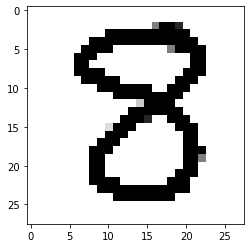

In [21]:

cur = cv2.resize(window, dsize=(28, 28), interpolation=cv2.INTER_CUBIC)
plt.imshow(cur, cmap=plt.cm.gray_r, interpolation='nearest')


In [16]:
#ToDo: Make True GUI buttons, make a numberdisplay that updates instead of a print, 
#make a function to save image with corrsponding targetlabel, make it web
#clean all code, make orderly filesystem